In [1]:
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
to_run = True
if to_run:
    os.chdir('..')
    to_run = False
print(os.getcwd())

/home/vco/Projects/pm4py-dcr4py/notebooks


In [2]:
import pandas as pd
import pm4py
from copy import deepcopy

Note: The pm4py library we use in the notebook is an extension with DCR from the original pm4py library. You will find more information on using pm4py here

https://pm4py.fit.fraunhofer.de/documentation.

# Event log data analysis
Note: sepsis_df is a pandas dataframe. Feel free to use your knowledge of data frames and data analysis as you see fit. Exploratory Data Analysis (EDA) as you know it from Data Science should work as expected.

In [5]:
event_log_file = 'notebooks/data/Sepsis Cases - Event Log.xes'
sepsis_df = pm4py.read_xes(event_log_file, infer_datetime_format=True) #loading the log
sepsis_df # note there are many NaN values, this is expected. When you have a not NaN value look at the concept:name to understand the link between the data attribute and the event.

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

,InfectionSuspected,org:group,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,concept:name,...,DiagnosticLacticAcid,lifecycle:transition,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,case:concept:name,Leucocytes,CRP,LacticAcid
0,True,A,True,True,True,True,True,True,True,ER Registration,...,True,complete,A,False,True,True,A,NaN,NaN,NaN
1,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leucocytes,...,NaN,complete,NaN,NaN,NaN,NaN,A,9.6,NaN,NaN
2,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,21.0,NaN
3,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LacticAcid,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,2.2
4,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,A,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15209,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CRP,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,66.0,NaN
15210,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Release A,...,NaN,complete,NaN,NaN,NaN,NaN,KNA,NaN,NaN,NaN
15211,False,L,False,False,False,False,False,False,False,ER Registration,...,False,complete,NaN,False,False,False,LNA,NaN,NaN,NaN
15212,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ER Triage,...,NaN,complete,NaN,NaN,NaN,NaN,LNA,NaN,NaN,NaN


In [6]:
returning = sepsis_df[sepsis_df['concept:name']=='Return ER']['case:concept:name'].unique().tolist()

# Part 2.1 Process discovery
Note: The model mined with this version of DisCoveR is more complex than the one from the dcrgraphs.net portal. It finds more relations.

Note 2: 'conditionsFor' represents the inverse reading of a condition arrow (this was done for efficient checking of the enabledness definition). 
    For example, you should read that 'Release D' is a conditionFor 'Return ER' ('Release D'-->*'Return ER'), but in the python object you will see it as 'conditionsFor': 'Return ER' {'Release D',...

Note 3: The other relations 'includesTo' (-->+), 'excludesTo' (-->%), 'responseTo' (*-->) are represented in the python object in the same direction as the arrows indicate. 
    For example, 'excludesTo': { ... 'Return ER': {'Return ER', 'Release B' ... encodes the visual self exclusion on 'Return ER' and that 'Return ER' excludes 'Release B' ('Return ER' -->% 'Release B') 

Inspect the mined DCR Graph from pm4py
[Found relations] 91
[conditionsFor] {'Return ER': {'Release C', 'Admission IC', 'Release D', 'Release E', 'Release A'}, 'Release C': {'ER Sepsis Triage', 'Leucocytes', 'Admission NC', 'CRP'}, 'Release D': {'ER Sepsis Triage', 'Leucocytes', 'Admission NC', 'CRP'}, 'Release E': {'Leucocytes', 'CRP', 'Admission NC', 'ER Sepsis Triage'}, 'Release B': {'ER Sepsis Triage', 'CRP', 'ER Registration', 'Leucocytes', 'ER Triage'}, 'Admission IC': {'ER Registration', 'ER Triage'}, 'Admission NC': {'ER Registration', 'ER Triage'}, 'Release A': {'ER Registration', 'ER Triage'}, 'IV Antibiotics': {'ER Sepsis Triage'}}
[excludesTo] {'Release B': {'Release B', 'Release C', 'Admission IC', 'Release D', 'Release E', 'CRP', 'Return ER', 'Leucocytes', 'ER Triage', 'Release A', 'LacticAcid'}, 'Release C': {'Release B', 'Release C', 'Admission IC', 'Release D', 'Release E', 'CRP', 'Leucocytes', 'ER Triage', 'Admission NC', 'Release A', 'LacticAcid'}, 'Admission IC': {'

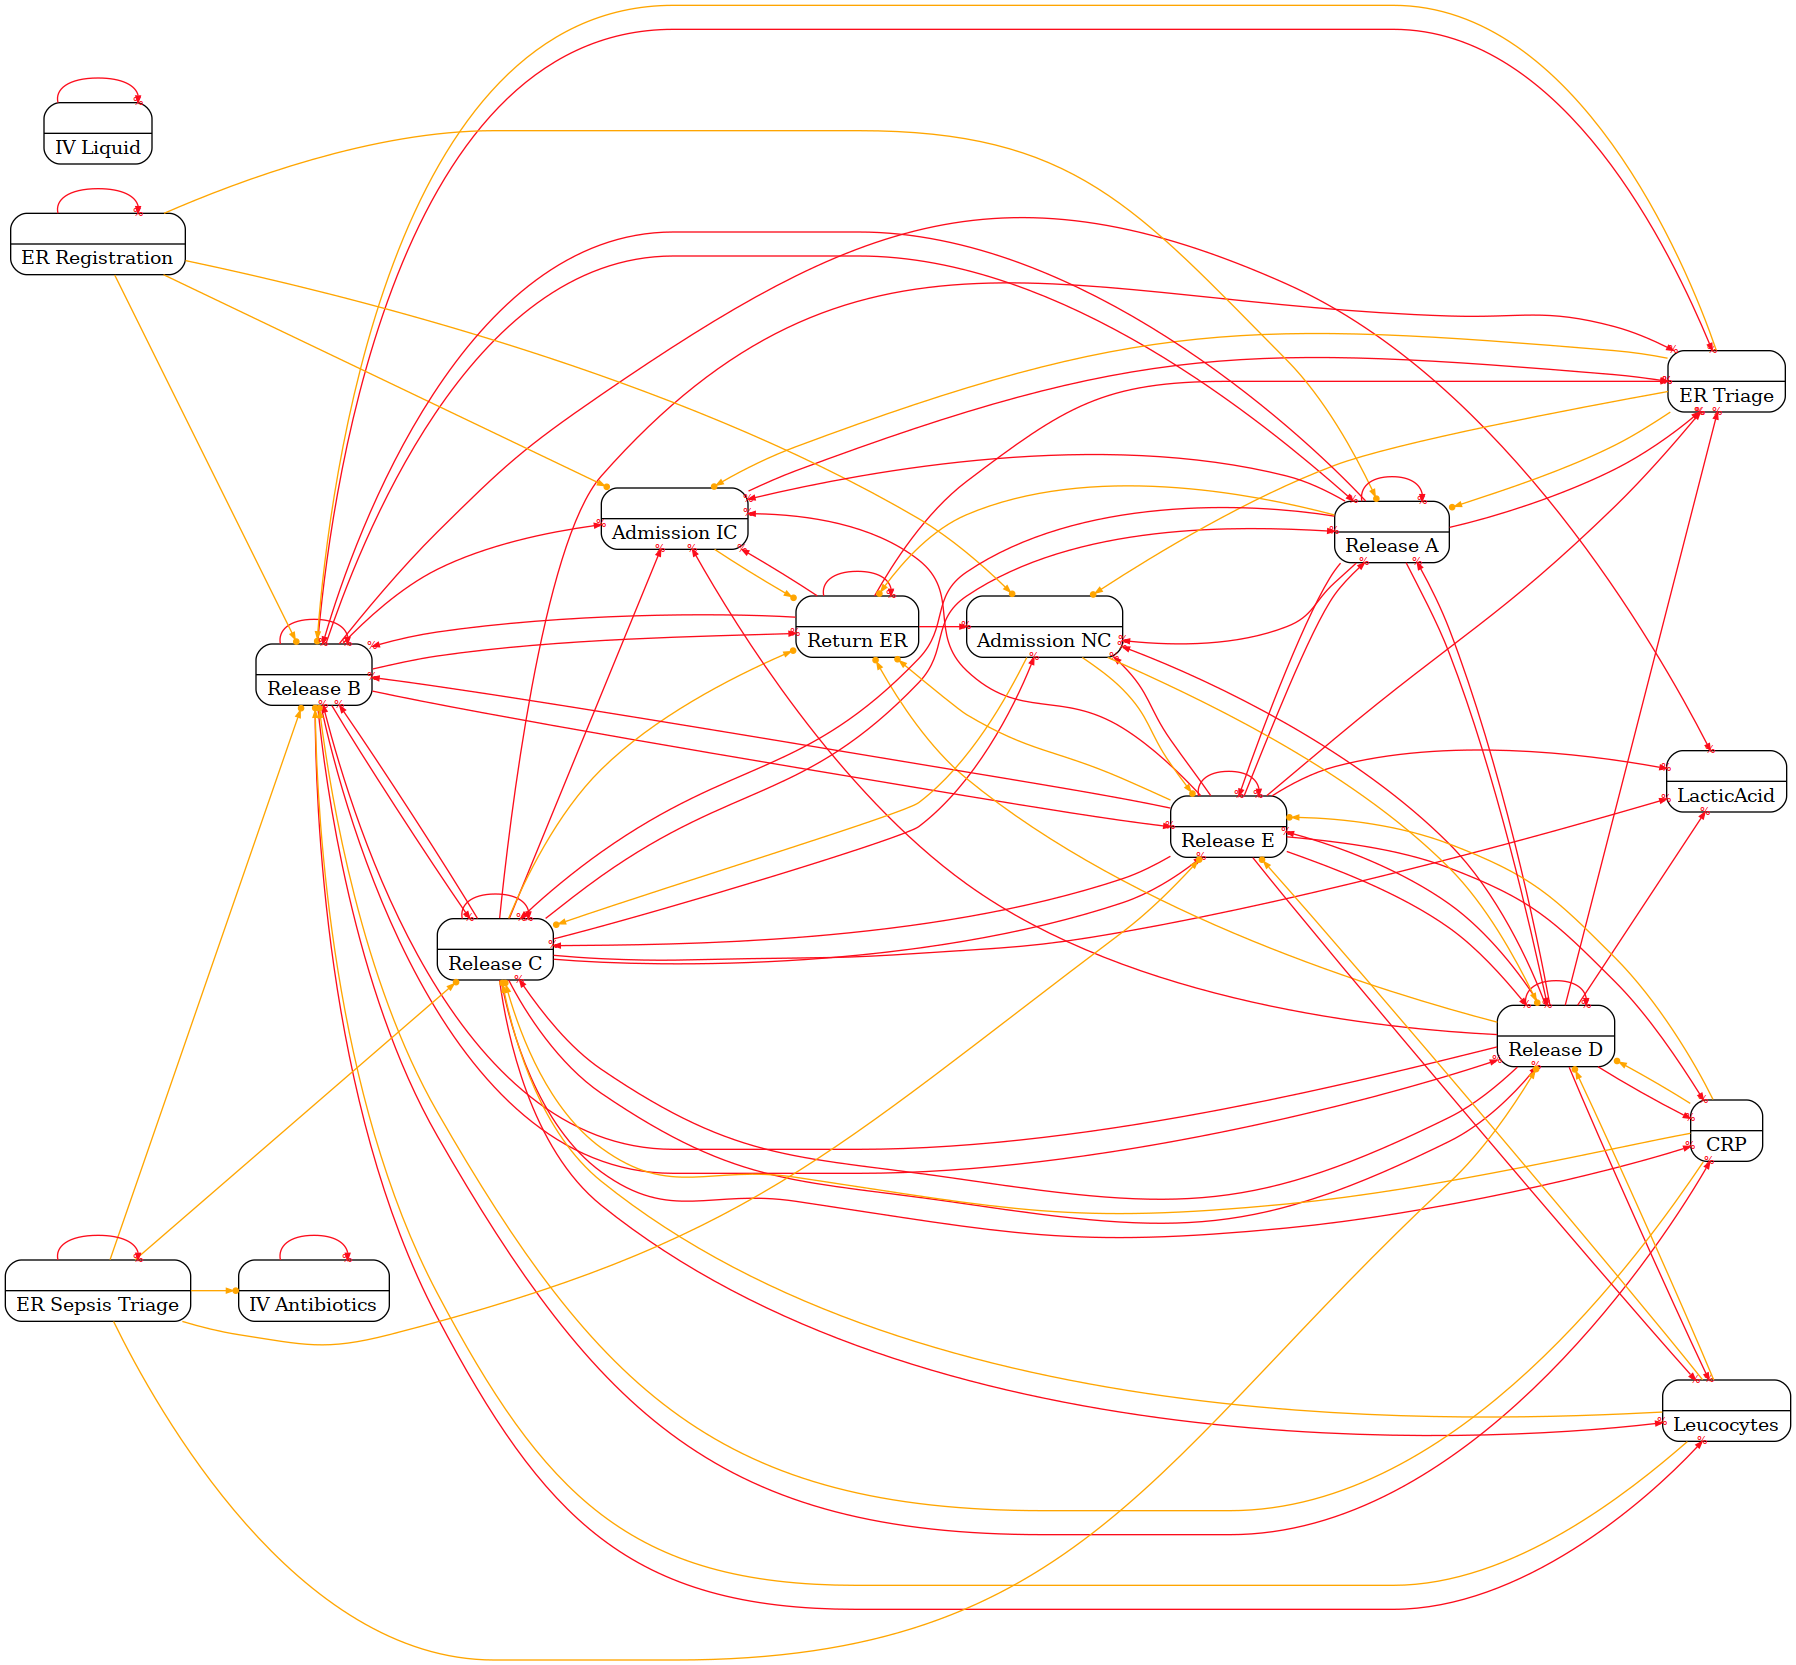

In [7]:
dcr_sepsis, log_abstraction = pm4py.discover_dcr(sepsis_df) # this discovers a model for the whole log
print('Inspect the mined DCR Graph from pm4py')
print(f'[Found relations] {dcr_sepsis.get_constraints()}')
print(f'[conditionsFor] {dcr_sepsis.conditions}')
print(f'[excludesTo] {dcr_sepsis.excludes}')
# when you discover (mine) a DCR Graph the marking you get will have all events included, none executed and none pending
print(f'[marking executed] {dcr_sepsis.marking.executed}')
print(f'[marking included] {dcr_sepsis.marking.included}')
print(f'[marking pending] {dcr_sepsis.marking.pending}')
pm4py.view_dcr(dcr_sepsis)

Example: play with the execution semantics in the notebook

In [8]:
def execute_and_check(event_to_execute,dcr_graph, dcr_semantics):
    enabled_events = dcr_semantics.enabled(dcr_graph)
    print(f'[Before executing {event_to_execute}] Enabled events: {enabled_events}') # check enabled events
    if event_to_execute in enabled_events: # check if I can execute the event_to_execute
        dcr_graph_new_marking = dcr_semantics.execute(dcr_graph,event_to_execute) # here you execute the event and change the state of the dcr graph
        print(f'[ After executing {event_to_execute}] Enabled events: {dcr_semantics.enabled(dcr_graph_new_marking)}') # now these are the newly enabled events
        print(f'[Is the graph accepting?] {dcr_semantics.is_accepting(dcr_graph_new_marking)}')
        return dcr_graph_new_marking
    else:
        print(f'[Error!] {event_to_execute} not in the set of enabled events')
        return dcr_graph

from pm4py.objects.dcr.semantics import DcrSemantics

temp_dcr = deepcopy(dcr_sepsis)
dcr_semantics = DcrSemantics()
event_to_execute1 = 'CRP' # update this event in order to simulate the execution of the event
temp_dcr = execute_and_check(event_to_execute1,temp_dcr,dcr_semantics)
event_to_execute2 = 'ER Sepsis Triage' # update this event in order to simulate the execution of the event
temp_dcr = execute_and_check(event_to_execute2,temp_dcr,dcr_semantics)

[Before executing CRP] Enabled events: {'IV Liquid', 'CRP', 'ER Registration', 'Leucocytes', 'LacticAcid', 'ER Sepsis Triage', 'ER Triage'}
[ After executing CRP] Enabled events: {'IV Liquid', 'CRP', 'ER Registration', 'Leucocytes', 'LacticAcid', 'ER Sepsis Triage', 'ER Triage'}
[Is the graph accepting?] True
[Before executing ER Sepsis Triage] Enabled events: {'IV Liquid', 'CRP', 'ER Registration', 'Leucocytes', 'LacticAcid', 'ER Sepsis Triage', 'ER Triage'}
[ After executing ER Sepsis Triage] Enabled events: {'IV Liquid', 'CRP', 'LacticAcid', 'ER Registration', 'Leucocytes', 'ER Triage', 'IV Antibiotics'}
[Is the graph accepting?] True


2.3 (in the notebook): Now I can make 'Release D' pending. This has an effect on my acceptance criteria. Also I cannot execute 'Release D' yet, because I have to satisfy the condition chain which will eventually enable 'Release D'.
What is the minimal sequence of events I need to execute before I am able to execute 'Release D' and return into an accepting state for my DCR Graph? 

In [9]:
temp_dcr = deepcopy(dcr_sepsis)
dcr_semantics = DcrSemantics()
temp_dcr.marking.pending.add('Release D')
print(f'[marking pending] {temp_dcr.marking.pending}')
#TODO: execute the minimum number of events to enable 'Release D'
for event in ['ER Registration','ER Triage', 'Admission NC', 'ER Sepsis Triage', 'CRP', 'Leucocytes', 'Release D']:
    temp_dcr = execute_and_check(event,temp_dcr,dcr_semantics)

[marking pending] {'Release D'}
[Before executing ER Registration] Enabled events: {'IV Liquid', 'CRP', 'ER Registration', 'Leucocytes', 'LacticAcid', 'ER Sepsis Triage', 'ER Triage'}
[ After executing ER Registration] Enabled events: {'IV Liquid', 'CRP', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'ER Triage'}
[Is the graph accepting?] False
[Before executing ER Triage] Enabled events: {'IV Liquid', 'CRP', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'ER Triage'}
[ After executing ER Triage] Enabled events: {'Admission IC', 'IV Liquid', 'CRP', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'ER Triage', 'Admission NC', 'Release A'}
[Is the graph accepting?] False
[Before executing Admission NC] Enabled events: {'Admission IC', 'IV Liquid', 'CRP', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'ER Triage', 'Admission NC', 'Release A'}
[ After executing Admission NC] Enabled events: {'Admission IC', 'IV Liquid', 'CRP', 'ER Sepsis Triage', 'LacticAcid', 'Leucocytes', 'ER Triage',

In [10]:
returning_df =sepsis_df[sepsis_df['case:concept:name'].isin(returning)]
non_returning_df = sepsis_df[~sepsis_df['case:concept:name'].isin(returning)]
#TODO: 1.5 run DisCoveR, export to the models folder, load them into the portal, run some descriptive statistics as seen above on the two subsets.
non_returning_dcr, _ = pm4py.discover_dcr(non_returning_df)
returning_dcr, _ = pm4py.discover_dcr(returning_df)

# Part 2.2 Conformance checking
### Rule based conformance checking
Note: Testing for conformance on the same data you used to discover your model will always be a perfect fit

In [11]:
conformance_sepsis_df = pd.DataFrame(pm4py.conformance_dcr(sepsis_df,dcr_sepsis))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]

[Deviation fitness] 1.0


,no_constr_total,deviations,no_dev_total,dev_fitness,is_fit


### Choice conformance

In [12]:
choice_graph = deepcopy(dcr_sepsis)
choice_graph.conditions = {}
choice_graph.excludes = {'Admission NC':{'Admission NC','Admission IC'},'Admission IC':{'Admission IC','Admission NC'}}

In [13]:
conformance_sepsis_df = pd.DataFrame(pm4py.conformance_dcr(sepsis_df, choice_graph))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
print(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts())

[Deviation fitness] 0.8709523809523809
Conforming traces: 685
Non-conforming traces 365
deviations
[(excludeViolation, (Admission NC, Admission NC))]                                                                                                                                                          265
[(excludeViolation, (Admission IC, Admission NC)), (excludeViolation, (Admission NC, Admission NC))]                                                                                                         58
[(excludeViolation, (Admission NC, Admission IC)), (excludeViolation, (Admission IC, Admission IC)), (excludeViolation, (Admission NC, Admission NC)), (excludeViolation, (Admission IC, Admission NC))]     23
[(excludeViolation, (Admission NC, Admission NC)), (excludeViolation, (Admission NC, Admission IC)), (excludeViolation, (Admission IC, Admission IC)), (excludeViolation, (Admission IC, Admission NC))]     12
[(excludeViolation, (Admission IC, Admission IC)), (excludeViolation,

In [14]:
conformance_sepsis_df = pd.DataFrame(pm4py.conformance_dcr(returning_df, choice_graph))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.8044217687074829
Conforming traces: 151
Non-conforming traces 143


deviations
[(excludeViolation, (Admission NC, Admission NC))]                                                                                                                                                          96
[(excludeViolation, (Admission IC, Admission NC)), (excludeViolation, (Admission NC, Admission NC))]                                                                                                        26
[(excludeViolation, (Admission NC, Admission IC)), (excludeViolation, (Admission IC, Admission IC)), (excludeViolation, (Admission NC, Admission NC)), (excludeViolation, (Admission IC, Admission NC))]    13
[(excludeViolation, (Admission NC, Admission NC)), (excludeViolation, (Admission NC, Admission IC)), (excludeViolation, (Admission IC, Admission IC)), (excludeViolation, (Admission IC, Admission NC))]     6
[(excludeViolation, (Admission NC, Admission NC)), (excludeViolation, (Admission NC, Admission IC)), (excludeViolation, (Admission IC, Admission IC))]           

In [15]:
conformance_sepsis_df = pd.DataFrame(pm4py.conformance_dcr(non_returning_df, choice_graph))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.8968253968253969
Conforming traces: 534
Non-conforming traces 222


deviations
[(excludeViolation, (Admission NC, Admission NC))]                                                                                                                                                          169
[(excludeViolation, (Admission IC, Admission NC)), (excludeViolation, (Admission NC, Admission NC))]                                                                                                         32
[(excludeViolation, (Admission NC, Admission IC)), (excludeViolation, (Admission IC, Admission IC)), (excludeViolation, (Admission NC, Admission NC)), (excludeViolation, (Admission IC, Admission NC))]     10
[(excludeViolation, (Admission NC, Admission NC)), (excludeViolation, (Admission NC, Admission IC)), (excludeViolation, (Admission IC, Admission IC)), (excludeViolation, (Admission IC, Admission NC))]      6
[(excludeViolation, (Admission IC, Admission IC)), (excludeViolation, (Admission IC, Admission NC)), (excludeViolation, (Admission NC, Admission NC))]       

### Sequence conformance

In [16]:
sequence_graph = deepcopy(dcr_sepsis)
sequence_graph.conditions = {'ER Triage': {'ER Registration'}, 'ER Sepsis Triage':{'ER Triage'}}
sequence_graph.excludes = {}
sequence_graph.responses = {'ER Registration': {'ER Triage'}, 'ER Triage': {'ER Sepsis Triage'}}

In [17]:
conformance_sepsis_df = pd.DataFrame(pm4py.conformance_dcr(sepsis_df,sequence_graph))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.9880952380952381
Conforming traces: 1024
Non-conforming traces 26


deviations
[(conditionViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Triage, ER Sepsis Triage))]                                                      17
[(conditionViolation, (ER Registration, ER Triage)), (responseViolation, (ER Registration, ER Triage))]                                                         5
[(responseViolation, (ER Triage, ER Sepsis Triage))]                                                                                                            3
[(conditionViolation, (ER Registration, ER Triage)), (responseViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Registration, ER Triage))]     1
Name: count, dtype: int64

In [18]:
conformance_sepsis_df = pd.DataFrame(pm4py.conformance_dcr(returning_df,sequence_graph))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.9812925170068028
Conforming traces: 283
Non-conforming traces 11


deviations
[(conditionViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Triage, ER Sepsis Triage))]                                                      6
[(conditionViolation, (ER Registration, ER Triage)), (responseViolation, (ER Registration, ER Triage))]                                                        3
[(conditionViolation, (ER Registration, ER Triage)), (responseViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Registration, ER Triage))]    1
[(responseViolation, (ER Triage, ER Sepsis Triage))]                                                                                                           1
Name: count, dtype: int64

In [19]:
conformance_sepsis_df = pd.DataFrame(pm4py.conformance_dcr(non_returning_df,sequence_graph))
print(f'[Deviation fitness] {conformance_sepsis_df["dev_fitness"].mean()}')
print('Conforming traces:',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==True]))
print('Non-conforming traces',len(conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]))
conformance_sepsis_df[conformance_sepsis_df['is_fit']==False]['deviations'].value_counts()

[Deviation fitness] 0.9907407407407407
Conforming traces: 741
Non-conforming traces 15


deviations
[(conditionViolation, (ER Triage, ER Sepsis Triage)), (responseViolation, (ER Triage, ER Sepsis Triage))]    11
[(responseViolation, (ER Triage, ER Sepsis Triage))]                                                          2
[(conditionViolation, (ER Registration, ER Triage)), (responseViolation, (ER Registration, ER Triage))]       2
Name: count, dtype: int64

## Alignment based conformance
Note: Testing for conformance on the same data you used to discover your model will always be a perfect fit

In [20]:
alignment_sepsis_df = pd.DataFrame(pm4py.optimal_alignment_dcr(sepsis_df,dcr_sepsis))
print(f'[Alignment fitness] {alignment_sepsis_df["fitness"].mean()}')
alignment_sepsis_df[alignment_sepsis_df['fitness']<1]

[Alignment fitness] 1.0


,alignment,cost,visited_states,closed,global_min,fitness,bwc


In [21]:
alignment_sepsis_df = pd.DataFrame(pm4py.optimal_alignment_dcr(sepsis_df,choice_graph))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()

[Deviation fitness] 0.9754106106361806
685
365


alignment
[(ER Registration, ER Registration), (ER Triage, ER Triage), (ER Sepsis Triage, ER Sepsis Triage), (Leucocytes, Leucocytes), (CRP, CRP), (LacticAcid, LacticAcid), (IV Liquid, IV Liquid), (IV Antibiotics, IV Antibiotics), (Admission NC, Admission NC), (>>, Admission NC), (Leucocytes, Leucocytes), (CRP, CRP), (Release A, Release A), (Return ER, Return ER)]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [22]:
alignment_sepsis_df = pd.DataFrame(pm4py.optimal_alignment_dcr(returning_df,choice_graph))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()

[Deviation fitness] 0.9679757032481192
151
143


alignment
[(ER Registration, ER Registration), (ER Triage, ER Triage), (ER Sepsis Triage, ER Sepsis Triage), (Leucocytes, Leucocytes), (CRP, CRP), (LacticAcid, LacticAcid), (IV Liquid, IV Liquid), (IV Antibiotics, IV Antibiotics), (Admission NC, Admission NC), (>>, Admission NC), (Leucocytes, Leucocytes), (CRP, CRP), (Release A, Release A), (Return ER, Return ER)]                                                                                                                                                                                                                                                                                                                              2
[(ER Registration, ER Registration), (ER Triage, ER Triage), (ER Sepsis Triage, ER Sepsis Triage), (LacticAcid, LacticAcid), (CRP, CRP), (Leucocytes, Leucocytes), (IV Liquid, IV Liquid), (IV Antibiotics, IV Antibiotics), (Admission NC, Admission NC), (>>, Admission IC), (Leucocytes, Leucocytes), (LacticAcid, Lact

In [23]:
alignment_sepsis_df = pd.DataFrame(pm4py.optimal_alignment_dcr(non_returning_df, choice_graph))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()

[Deviation fitness] 0.9783019635093154
534
222


alignment
[(ER Registration, ER Registration), (ER Triage, ER Triage), (ER Sepsis Triage, ER Sepsis Triage), (Leucocytes, Leucocytes), (CRP, CRP), (LacticAcid, LacticAcid), (IV Liquid, IV Liquid), (IV Antibiotics, IV Antibiotics), (Admission NC, Admission NC), (Leucocytes, Leucocytes), (CRP, CRP), (>>, Admission NC), (Leucocytes, Leucocytes), (CRP, CRP), (Release A, Release A)]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [24]:
alignment_sepsis_df = pd.DataFrame(pm4py.optimal_alignment_dcr(sepsis_df,sequence_graph))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()

[Deviation fitness] 0.9961642116273915
1024
26


alignment
[(>>, ER Sepsis Triage), (ER Registration, ER Registration), (ER Triage, ER Triage), (Leucocytes, Leucocytes), (CRP, CRP), (ER Sepsis Triage, >>)]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1
[(ER Registration, ER Registration), (>>, ER Sepsis Triage), (IV Antibiotics, IV Antibiotics), (ER Triage, ER Triage), (CRP, CRP), (Le

In [25]:
alignment_sepsis_df = pd.DataFrame(pm4py.optimal_alignment_dcr(returning_df,sequence_graph))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()

[Deviation fitness] 0.9951645218526971
283
11


alignment
[(>>, ER Triage), (ER Registration, ER Registration), (ER Triage, >>), (ER Sepsis Triage, ER Sepsis Triage), (IV Liquid, IV Liquid), (IV Antibiotics, IV Antibiotics), (Leucocytes, Leucocytes), (CRP, CRP), (LacticAcid, LacticAcid), (Admission NC, Admission NC), (Leucocytes, Leucocytes), (Release A, Release A), (Return ER, Return ER)]                                                                                                                                                                                                                                                                                                                                                                                                                              1
[(ER Registration, ER Registration), (ER Triage, >>), (ER Sepsis Triage, ER Sepsis Triage), (IV Antibiotics, IV Antibiotics), (ER Triage, ER Triage), (Leucocytes, Leucocytes), (LacticAcid, LacticAcid), (CRP, CRP), (Admission NC, Admission N

In [26]:
alignment_sepsis_df = pd.DataFrame(pm4py.optimal_alignment_dcr(non_returning_df,sequence_graph))
print(f'[Deviation fitness] {alignment_sepsis_df["fitness"].mean()}')
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']==1]))
print(len(alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]))
alignment_sepsis_df[alignment_sepsis_df['fitness']!=1]['alignment'].value_counts()

[Deviation fitness] 0.9965529798731061
741
15


alignment
[(>>, ER Sepsis Triage), (ER Registration, ER Registration), (ER Triage, ER Triage), (Leucocytes, Leucocytes), (CRP, CRP), (ER Sepsis Triage, >>)]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    1
[(ER Registration, ER Registration), (>>, ER Sepsis Triage), (IV Antibiotics, IV Antibiotics), (ER Triage, ER Triage), (CRP, CRP), (Le